# ModelNet40 to PCN 数据集转换工具

这个notebook展示了如何将ModelNet40分类数据集转换为PCN风格的点云补全数据集，支持多种遮挡策略和数据增强方法。

## 项目概述

点云补全任务需要配对的数据集：每个样本包含一个不完整的点云和对应的完整点云。本项目通过从ModelNet40数据集生成人工遮挡的不完整点云，构造出类似PCN数据集的点云补全训练数据。

## 主要特性

- 🎯 **多遮挡策略**：支持随机、视角、距离、平面等多种遮挡方式
- 📊 **数据增强**：旋转、缩放、噪声等增强方法
- 🔧 **灵活配置**：可自定义遮挡比例、策略组合等参数
- 📈 **可视化支持**：直观展示遮挡效果和数据集统计


## 1. 环境设置和依赖安装


In [23]:
# 安装必要的依赖包
%pip install torch torchvision matplotlib numpy scipy scikit-learn tqdm plotly

# 导入必要的库
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import os
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import random

# 检查设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")
print(f"PyTorch版本: {torch.__version__}")


Note: you may need to restart the kernel to use updated packages.
使用设备: cpu
PyTorch版本: 2.8.0


## 2. 遮挡策略实现


In [24]:
# 定义多种点云遮挡策略
class OcclusionStrategies:
    """点云遮挡策略集合"""
    
    @staticmethod
    def random_occlusion(pc, completion_ratio=0.5):
        """
        随机遮挡：随机移除指定比例的点
        Args:
            pc: 完整点云 (N, 3)
            completion_ratio: 保留比例
        Returns:
            partial_pc: 不完整点云
        """
        num_points = len(pc)
        num_keep = int(num_points * completion_ratio)
        
        # 随机选择要保留的点
        indices = np.random.choice(num_points, num_keep, replace=False)
        partial_pc = pc[indices]
        
        return partial_pc
    
    @staticmethod
    def view_occlusion(pc, view_angle=120):
        """
        视角遮挡：从特定视角移除点
        Args:
            pc: 完整点云 (N, 3)
            view_angle: 视角范围（度）
        Returns:
            partial_pc: 不完整点云
        """
        # 计算每个点相对于原点的角度
        angles = np.arctan2(pc[:, 1], pc[:, 0]) * 180 / np.pi
        
        # 选择特定角度范围内的点
        mask = (angles >= -view_angle/2) & (angles <= view_angle/2)
        partial_pc = pc[mask]
        
        return partial_pc
    
    @staticmethod
    def distance_occlusion(pc, max_distance=1.0):
        """
        距离遮挡：移除远距离的点
        Args:
            pc: 完整点云 (N, 3)
            max_distance: 最大保留距离
        Returns:
            partial_pc: 不完整点云
        """
        # 计算每个点到原点的距离
        distances = np.linalg.norm(pc, axis=1)
        
        # 保留距离小于阈值的点
        mask = distances <= max_distance
        partial_pc = pc[mask]
        
        return partial_pc
    
    @staticmethod
    def plane_occlusion(pc, normal=None, point_on_plane=None):
        """
        平面遮挡：使用平面切割移除点
        Args:
            pc: 完整点云 (N, 3)
            normal: 平面法向量
            point_on_plane: 平面上的点
        Returns:
            partial_pc: 不完整点云
        """
        if normal is None:
            # 随机选择一个平面法向量
            normal = np.random.randn(3)
            normal = normal / np.linalg.norm(normal)
        
        if point_on_plane is None:
            # 随机选择平面上的点
            point_on_plane = np.random.randn(3)
        
        # 计算点到平面的距离
        distances = np.dot(pc - point_on_plane, normal)
        mask = distances >= 0  # 保留平面一侧的点
        partial_pc = pc[mask]
        
        return partial_pc
    
    @staticmethod
    def noise_occlusion(pc, noise_level=0.1, keep_ratio=0.7):
        """
        噪声遮挡：添加噪声后移除异常点
        Args:
            pc: 完整点云 (N, 3)
            noise_level: 噪声水平
            keep_ratio: 保留比例
        Returns:
            partial_pc: 不完整点云
        """
        # 添加高斯噪声
        noise = np.random.normal(0, noise_level, pc.shape)
        noisy_pc = pc + noise
        
        # 移除距离中心过远的点
        center = np.mean(pc, axis=0)
        distances = np.linalg.norm(noisy_pc - center, axis=1)
        threshold = np.percentile(distances, keep_ratio * 100)
        mask = distances <= threshold
        partial_pc = noisy_pc[mask]
        
        return partial_pc
    
    @staticmethod
    def height_occlusion(pc, height_threshold=0.5):
        """
        高度遮挡：移除指定高度以下的点
        Args:
            pc: 完整点云 (N, 3)
            height_threshold: 高度阈值
        Returns:
            partial_pc: 不完整点云
        """
        mask = pc[:, 2] >= height_threshold
        partial_pc = pc[mask]
        
        return partial_pc

print("遮挡策略定义完成！")


遮挡策略定义完成！


## 2.1 真实遮挡策略（改进版）


In [25]:
# 真实遮挡策略 - 模拟真实世界中的遮挡情况
class RealisticOcclusionStrategies:
    """真实遮挡策略集合 - 模拟真实世界中的遮挡情况"""
    
    @staticmethod
    def single_view_occlusion(pc, camera_position=None, occlusion_ratio=0.3):
        """
        单视角遮挡：模拟从单一视角扫描时的遮挡
        真实场景：激光雷达只能扫描到面向传感器的表面
        Args:
            pc: 完整点云 (N, 3)
            camera_position: 相机位置，默认为原点
            occlusion_ratio: 遮挡比例
        Returns:
            partial_pc: 不完整点云
        """
        if camera_position is None:
            camera_position = np.array([0, 0, -2])  # 相机在Z轴负方向
        
        # 计算每个点到相机的距离和角度
        vectors = pc - camera_position
        distances = np.linalg.norm(vectors, axis=1)
        
        # 归一化向量
        normalized_vectors = vectors / distances[:, np.newaxis]
        
        # 计算视角（相对于Z轴的角度）
        view_angles = np.arccos(np.abs(normalized_vectors[:, 2]))
        view_angles = view_angles * 180 / np.pi  # 转换为度
        
        # 保留视角小于阈值的点（面向相机的点）
        angle_threshold = 60  # 60度视角
        visible_mask = view_angles <= angle_threshold
        
        # 如果可见点太少，调整阈值
        while np.sum(visible_mask) < len(pc) * (1 - occlusion_ratio):
            angle_threshold += 10
            visible_mask = view_angles <= angle_threshold
            if angle_threshold >= 90:
                break
        
        return pc[visible_mask]
    
    @staticmethod
    def wall_occlusion(pc, wall_position=0.5, wall_normal=None):
        """
        墙面遮挡：模拟被墙面遮挡的情况
        真实场景：物体被墙壁、家具等遮挡
        Args:
            pc: 完整点云 (N, 3)
            wall_position: 墙面位置
            wall_normal: 墙面法向量，默认为X轴方向
        Returns:
            partial_pc: 不完整点云
        """
        if wall_normal is None:
            wall_normal = np.array([1, 0, 0])  # X轴方向的墙面
        
        # 计算每个点到墙面的距离
        distances = np.dot(pc, wall_normal) - wall_position
        
        # 保留墙面后面的点（被遮挡的点）
        occluded_mask = distances < 0
        return pc[occluded_mask]
    
    @staticmethod
    def object_occlusion(pc, occluder_center=None, occluder_size=0.3):
        """
        物体遮挡：模拟被其他物体遮挡
        真实场景：一个物体被另一个物体部分遮挡
        Args:
            pc: 完整点云 (N, 3)
            occluder_center: 遮挡物体中心位置
            occluder_size: 遮挡物体大小
        Returns:
            partial_pc: 不完整点云
        """
        if occluder_center is None:
            # 随机选择遮挡物体位置
            occluder_center = np.random.uniform(-0.5, 0.5, 3)
        
        # 计算每个点到遮挡物体的距离
        distances = np.linalg.norm(pc - occluder_center, axis=1)
        
        # 保留距离遮挡物体较远的点
        mask = distances > occluder_size
        return pc[mask]
    
    @staticmethod
    def partial_scan_occlusion(pc, scan_angle=180):
        """
        部分扫描遮挡：模拟激光雷达扫描角度限制
        真实场景：激光雷达有扫描角度限制，无法看到所有方向
        Args:
            pc: 完整点云 (N, 3)
            scan_angle: 扫描角度（度）
        Returns:
            partial_pc: 不完整点云
        """
        # 计算每个点的方位角
        azimuth_angles = np.arctan2(pc[:, 1], pc[:, 0]) * 180 / np.pi
        azimuth_angles = (azimuth_angles + 360) % 360
        
        # 计算每个点的仰角
        distances_xy = np.sqrt(pc[:, 0]**2 + pc[:, 1]**2)
        elevation_angles = np.arctan2(pc[:, 2], distances_xy) * 180 / np.pi
        
        # 保留扫描范围内的点
        azimuth_mask = azimuth_angles <= scan_angle
        elevation_mask = np.abs(elevation_angles) <= 30  # 仰角限制在±30度
        
        mask = azimuth_mask & elevation_mask
        return pc[mask]
    
    @staticmethod
    def sensor_noise_occlusion(pc, noise_level=0.02, dropout_ratio=0.1):
        """
        传感器噪声遮挡：模拟传感器噪声和丢点
        真实场景：激光雷达在远距离或反射率低的表面容易丢点
        Args:
            pc: 完整点云 (N, 3)
            noise_level: 噪声强度
            dropout_ratio: 丢点比例
        Returns:
            partial_pc: 不完整点云
        """
        # 计算每个点到原点的距离
        distances = np.linalg.norm(pc, axis=1)
        
        # 距离越远，丢点概率越高
        dropout_prob = dropout_ratio * (distances / np.max(distances))
        dropout_mask = np.random.random(len(pc)) > dropout_prob
        
        # 添加距离相关的噪声
        noise = np.random.normal(0, noise_level, pc.shape)
        # 距离越远，噪声越大
        distance_factor = distances / np.max(distances)
        noise = noise * distance_factor[:, np.newaxis]
        
        noisy_pc = pc + noise
        return noisy_pc[dropout_mask]
    
    @staticmethod
    def ground_occlusion(pc, ground_height=-0.2):
        """
        地面遮挡：模拟地面遮挡下方物体
        真实场景：地面遮挡了物体的下半部分
        Args:
            pc: 完整点云 (N, 3)
            ground_height: 地面高度
        Returns:
            partial_pc: 不完整点云
        """
        # 保留地面以上的点
        mask = pc[:, 2] > ground_height
        return pc[mask]
    
    @staticmethod
    def mixed_occlusion(pc, strategies=['single_view', 'object'], weights=None):
        """
        混合遮挡：组合多种遮挡策略
        真实场景：同时存在多种遮挡情况
        Args:
            pc: 完整点云 (N, 3)
            strategies: 遮挡策略列表
            weights: 各策略权重
        Returns:
            partial_pc: 不完整点云
        """
        if weights is None:
            weights = [1.0] * len(strategies)
        
        # 随机选择一种策略应用
        strategy_idx = np.random.choice(len(strategies), p=np.array(weights)/sum(weights))
        strategy = strategies[strategy_idx]
        
        if strategy == 'single_view':
            return RealisticOcclusionStrategies.single_view_occlusion(pc)
        elif strategy == 'wall':
            return RealisticOcclusionStrategies.wall_occlusion(pc)
        elif strategy == 'object':
            return RealisticOcclusionStrategies.object_occlusion(pc)
        elif strategy == 'partial_scan':
            return RealisticOcclusionStrategies.partial_scan_occlusion(pc)
        elif strategy == 'sensor_noise':
            return RealisticOcclusionStrategies.sensor_noise_occlusion(pc)
        elif strategy == 'ground':
            return RealisticOcclusionStrategies.ground_occlusion(pc)
        else:
            return pc

print("真实遮挡策略定义完成！")


真实遮挡策略定义完成！


## 2.2 真实遮挡策略演示


In [26]:
# 演示真实遮挡策略的效果
print("演示真实遮挡策略的效果...")

# 选择一个样本进行不同策略的演示
original_sample = modelnet_dataset[0]  # 选择一个样本
original_pc = original_sample['point_cloud']
class_name = original_sample['class_name']

# 应用不同的真实遮挡策略
realistic_strategies = ['single_view', 'wall', 'object', 'partial_scan', 'sensor_noise', 'ground']
occluded_pcs = []

for strategy in realistic_strategies:
    if strategy == 'single_view':
        occluded_pc = RealisticOcclusionStrategies.single_view_occlusion(original_pc)
    elif strategy == 'wall':
        occluded_pc = RealisticOcclusionStrategies.wall_occlusion(original_pc)
    elif strategy == 'object':
        occluded_pc = RealisticOcclusionStrategies.object_occlusion(original_pc)
    elif strategy == 'partial_scan':
        occluded_pc = RealisticOcclusionStrategies.partial_scan_occlusion(original_pc)
    elif strategy == 'sensor_noise':
        occluded_pc = RealisticOcclusionStrategies.sensor_noise_occlusion(original_pc)
    elif strategy == 'ground':
        occluded_pc = RealisticOcclusionStrategies.ground_occlusion(original_pc)
    
    occluded_pcs.append(occluded_pc)

# 使用Plotly创建对比图
fig = make_subplots(
    rows=3, cols=3,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}],
           [{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}],
           [{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    subplot_titles=[
        f'{class_name} - 原始完整点云',
        f'{realistic_strategies[0]}遮挡',
        f'{realistic_strategies[1]}遮挡',
        f'{realistic_strategies[2]}遮挡',
        f'{realistic_strategies[3]}遮挡',
        f'{realistic_strategies[4]}遮挡',
        f'{realistic_strategies[5]}遮挡',
        '混合遮挡',
        '对比说明'
    ]
)

# 原始完整点云
fig.add_trace(
    go.Scatter3d(
        x=original_pc[:, 0],
        y=original_pc[:, 1],
        z=original_pc[:, 2],
        mode='markers',
        marker=dict(
            size=2,
            color='blue',
            opacity=0.8
        ),
        name='原始',
        showlegend=False
    ),
    row=1, col=1
)

# 不同真实遮挡策略的结果
colors = ['red', 'green', 'orange', 'purple', 'brown', 'pink']
for i, (strategy, occluded_pc, color) in enumerate(zip(realistic_strategies, occluded_pcs, colors)):
    row = (i + 1) // 3 + 1
    col = (i + 1) % 3 + 1
    
    fig.add_trace(
        go.Scatter3d(
            x=occluded_pc[:, 0],
            y=occluded_pc[:, 1],
            z=occluded_pc[:, 2],
            mode='markers',
            marker=dict(
                size=2,
                color=color,
                opacity=0.8
            ),
            name=strategy,
            showlegend=False
        ),
        row=row, col=col
    )

# 混合遮挡
mixed_occluded_pc = RealisticOcclusionStrategies.mixed_occlusion(original_pc)
fig.add_trace(
    go.Scatter3d(
        x=mixed_occluded_pc[:, 0],
        y=mixed_occluded_pc[:, 1],
        z=mixed_occluded_pc[:, 2],
        mode='markers',
        marker=dict(
            size=2,
            color='cyan',
            opacity=0.8
        ),
        name='mixed',
        showlegend=False
    ),
    row=3, col=1
)

# 更新布局
fig.update_layout(
    title=f"{class_name} - 真实遮挡策略对比展示",
    height=1000,
    width=1200,
    showlegend=False
)

# 设置场景属性
for i in range(1, 10):
    row = (i-1) // 3 + 1
    col = (i-1) % 3 + 1
    fig.update_scenes(
        aspectmode='cube',
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        row=row, col=col
    )

fig.show()

print("\\n真实遮挡策略说明:")
print("- Single View: 单视角遮挡，模拟激光雷达视角限制")
print("- Wall: 墙面遮挡，模拟被墙壁遮挡")
print("- Object: 物体遮挡，模拟被其他物体遮挡")
print("- Partial Scan: 部分扫描，模拟激光雷达扫描角度限制")
print("- Sensor Noise: 传感器噪声，模拟远距离丢点")
print("- Ground: 地面遮挡，模拟地面遮挡下半部分")
print("- Mixed: 混合遮挡，随机组合多种策略")


演示真实遮挡策略的效果...


\n真实遮挡策略说明:
- Single View: 单视角遮挡，模拟激光雷达视角限制
- Wall: 墙面遮挡，模拟被墙壁遮挡
- Object: 物体遮挡，模拟被其他物体遮挡
- Partial Scan: 部分扫描，模拟激光雷达扫描角度限制
- Sensor Noise: 传感器噪声，模拟远距离丢点
- Ground: 地面遮挡，模拟地面遮挡下半部分
- Mixed: 混合遮挡，随机组合多种策略


## 3. 数据增强工具


In [27]:
# 定义数据增强工具
class DataAugmentation:
    """点云数据增强工具"""
    
    @staticmethod
    def rotate_pointcloud(pc, angle_range=30):
        """
        随机旋转点云
        Args:
            pc: 点云 (N, 3)
            angle_range: 旋转角度范围（度）
        Returns:
            rotated_pc: 旋转后的点云
        """
        angle = np.random.uniform(-angle_range, angle_range)
        angle_rad = np.radians(angle)
        
        cos_angle = np.cos(angle_rad)
        sin_angle = np.sin(angle_rad)
        
        # 绕Z轴旋转
        rotation_matrix = np.array([
            [cos_angle, -sin_angle, 0],
            [sin_angle, cos_angle, 0],
            [0, 0, 1]
        ])
        
        return np.dot(pc, rotation_matrix.T)
    
    @staticmethod
    def scale_pointcloud(pc, scale_range=(0.8, 1.2)):
        """
        随机缩放点云
        Args:
            pc: 点云 (N, 3)
            scale_range: 缩放范围
        Returns:
            scaled_pc: 缩放后的点云
        """
        scale = np.random.uniform(scale_range[0], scale_range[1])
        return pc * scale
    
    @staticmethod
    def jitter_pointcloud(pc, sigma=0.01):
        """
        添加高斯噪声
        Args:
            pc: 点云 (N, 3)
            sigma: 噪声标准差
        Returns:
            jittered_pc: 添加噪声后的点云
        """
        noise = np.random.normal(0, sigma, pc.shape)
        return pc + noise
    
    @staticmethod
    def translate_pointcloud(pc, translation_range=0.1):
        """
        随机平移点云
        Args:
            pc: 点云 (N, 3)
            translation_range: 平移范围
        Returns:
            translated_pc: 平移后的点云
        """
        translation = np.random.uniform(-translation_range, translation_range, 3)
        return pc + translation
    
    @staticmethod
    def apply_random_augmentation(pc, augmentation_config):
        """
        应用随机数据增强
        Args:
            pc: 点云 (N, 3)
            augmentation_config: 增强配置
        Returns:
            augmented_pc: 增强后的点云
        """
        augmented_pc = pc.copy()
        
        if augmentation_config.get('rotation', False):
            augmented_pc = DataAugmentation.rotate_pointcloud(
                augmented_pc, 
                augmentation_config.get('rotation_range', 30)
            )
        
        if augmentation_config.get('scaling', False):
            augmented_pc = DataAugmentation.scale_pointcloud(
                augmented_pc,
                augmentation_config.get('scale_range', (0.8, 1.2))
            )
        
        if augmentation_config.get('jittering', False):
            augmented_pc = DataAugmentation.jitter_pointcloud(
                augmented_pc,
                augmentation_config.get('jitter_sigma', 0.01)
            )
        
        if augmentation_config.get('translation', False):
            augmented_pc = DataAugmentation.translate_pointcloud(
                augmented_pc,
                augmentation_config.get('translation_range', 0.1)
            )
        
        return augmented_pc

print("数据增强工具定义完成！")


数据增强工具定义完成！


## 4. 合成ModelNet40数据集（用于演示）


In [28]:
# 创建合成ModelNet40数据集（用于演示）
# 在实际应用中，您需要下载真实的ModelNet40数据集

class SyntheticModelNet40Dataset:
    """合成ModelNet40数据集，用于演示目的"""
    
    def __init__(self, num_samples_per_class=20, num_points=2048):
        self.num_samples_per_class = num_samples_per_class
        self.num_points = num_points
        self.classes = [
            'airplane', 'bathtub', 'bed', 'bench', 'bookshelf',
            'bottle', 'bowl', 'car', 'chair', 'cone',
            'cup', 'curtain', 'desk', 'door', 'dresser',
            'flower_pot', 'glass_box', 'guitar', 'keyboard', 'lamp',
            'laptop', 'mantel', 'monitor', 'night_stand', 'person',
            'piano', 'plant', 'radio', 'range_hood', 'sink',
            'sofa', 'stairs', 'stool', 'table', 'tent',
            'toilet', 'tv_stand', 'vase', 'wardrobe', 'xbox'
        ]
        
        self.data = self._generate_synthetic_data()
    
    def _generate_synthetic_data(self):
        """生成合成数据"""
        print("生成合成ModelNet40数据集...")
        data = []
        
        for class_idx, class_name in enumerate(self.classes):
            for sample_idx in range(self.num_samples_per_class):
                # 根据类别生成不同形状的点云
                point_cloud = self._generate_shape_for_class(class_name)
                
                data.append({
                    'point_cloud': point_cloud,
                    'label': class_idx,
                    'class_name': class_name,
                    'model_id': f"{class_name}_{sample_idx}"
                })
            
            print(f"已生成 {class_name} 类别数据: {self.num_samples_per_class} 个样本")
        
        print(f"总共生成 {len(data)} 个样本")
        return data
    
    def _generate_shape_for_class(self, class_name):
        """根据类别名称生成对应的点云形状"""
        if class_name in ['airplane', 'car']:
            return self._generate_elongated_shape()
        elif class_name in ['chair', 'stool', 'table']:
            return self._generate_furniture_shape()
        elif class_name in ['bottle', 'cup', 'vase']:
            return self._generate_cylinder_shape()
        elif class_name in ['bowl', 'sink', 'bathtub']:
            return self._generate_bowl_shape()
        elif class_name in ['lamp', 'flower_pot', 'plant']:
            return self._generate_tall_shape()
        else:
            return self._generate_generic_shape()
    
    def _generate_elongated_shape(self):
        """生成长条形物体（飞机、汽车）"""
        # 生成长方体并添加细节
        x = np.random.uniform(-1.5, 1.5, self.num_points)
        y = np.random.uniform(-0.5, 0.5, self.num_points)
        z = np.random.uniform(-0.3, 0.3, self.num_points)
        
        # 添加一些噪声和细节
        noise = np.random.normal(0, 0.05, (self.num_points, 3))
        points = np.column_stack([x, y, z]) + noise
        
        return points
    
    def _generate_furniture_shape(self):
        """生成家具形状（椅子、桌子）"""
        points = []
        
        # 主体
        x = np.random.uniform(-1, 1, self.num_points // 2)
        y = np.random.uniform(-1, 1, self.num_points // 2)
        z = np.random.uniform(-0.8, 0.8, self.num_points // 2)
        points.append(np.column_stack([x, y, z]))
        
        # 支撑结构
        x_support = np.random.uniform(-0.1, 0.1, self.num_points // 2)
        y_support = np.random.uniform(-0.1, 0.1, self.num_points // 2)
        z_support = np.random.uniform(-1, 1, self.num_points // 2)
        points.append(np.column_stack([x_support, y_support, z_support]))
        
        return np.vstack(points)
    
    def _generate_cylinder_shape(self):
        """生成圆柱形物体（瓶子、杯子）"""
        radius = 0.5
        height = 1.5
        
        # 圆柱面
        theta = np.random.uniform(0, 2 * np.pi, self.num_points // 2)
        z_cyl = np.random.uniform(-height/2, height/2, self.num_points // 2)
        x_cyl = radius * np.cos(theta)
        y_cyl = radius * np.sin(theta)
        points = [np.column_stack([x_cyl, y_cyl, z_cyl])]
        
        # 底面
        r_disk = np.random.uniform(0, radius, self.num_points // 4)
        theta_disk = np.random.uniform(0, 2 * np.pi, self.num_points // 4)
        x_disk = r_disk * np.cos(theta_disk)
        y_disk = r_disk * np.sin(theta_disk)
        z_disk = np.full(self.num_points // 4, -height/2)
        points.append(np.column_stack([x_disk, y_disk, z_disk]))
        
        # 顶面
        r_disk = np.random.uniform(0, radius, self.num_points // 4)
        theta_disk = np.random.uniform(0, 2 * np.pi, self.num_points // 4)
        x_disk = r_disk * np.cos(theta_disk)
        y_disk = r_disk * np.sin(theta_disk)
        z_disk = np.full(self.num_points // 4, height/2)
        points.append(np.column_stack([x_disk, y_disk, z_disk]))
        
        return np.vstack(points)
    
    def _generate_bowl_shape(self):
        """生成碗形物体"""
        radius = 1.0
        depth = 0.5
        
        # 碗面
        theta = np.random.uniform(0, 2 * np.pi, self.num_points // 2)
        r = np.random.uniform(0, radius, self.num_points // 2)
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        z = -np.sqrt(radius**2 - r**2) + depth
        points = [np.column_stack([x, y, z])]
        
        # 底面
        r_disk = np.random.uniform(0, radius * 0.8, self.num_points // 2)
        theta_disk = np.random.uniform(0, 2 * np.pi, self.num_points // 2)
        x_disk = r_disk * np.cos(theta_disk)
        y_disk = r_disk * np.sin(theta_disk)
        z_disk = np.full(self.num_points // 2, depth)
        points.append(np.column_stack([x_disk, y_disk, z_disk]))
        
        return np.vstack(points)
    
    def _generate_tall_shape(self):
        """生成高瘦物体（台灯、花瓶）"""
        # 主体（细圆柱）
        radius = 0.2
        height = 2.0
        
        theta = np.random.uniform(0, 2 * np.pi, self.num_points // 2)
        z_cyl = np.random.uniform(-height/2, height/2, self.num_points // 2)
        x_cyl = radius * np.cos(theta)
        y_cyl = radius * np.sin(theta)
        points = [np.column_stack([x_cyl, y_cyl, z_cyl])]
        
        # 顶部扩展
        x_top = np.random.uniform(-0.8, 0.8, self.num_points // 4)
        y_top = np.random.uniform(-0.8, 0.8, self.num_points // 4)
        z_top = np.full(self.num_points // 4, height/2 + 0.3)
        points.append(np.column_stack([x_top, y_top, z_top]))
        
        # 底部
        x_bottom = np.random.uniform(-0.4, 0.4, self.num_points // 4)
        y_bottom = np.random.uniform(-0.4, 0.4, self.num_points // 4)
        z_bottom = np.full(self.num_points // 4, -height/2)
        points.append(np.column_stack([x_bottom, y_bottom, z_bottom]))
        
        return np.vstack(points)
    
    def _generate_generic_shape(self):
        """生成通用形状"""
        # 生成不规则的3D形状
        phi = np.random.uniform(0, 2 * np.pi, self.num_points)
        cos_theta = np.random.uniform(-1, 1, self.num_points)
        theta = np.arccos(cos_theta)
        radius = 0.8 + 0.4 * np.random.random(self.num_points)
        
        x = radius * np.sin(theta) * np.cos(phi)
        y = radius * np.sin(theta) * np.sin(phi)
        z = radius * np.cos(theta)
        
        return np.column_stack([x, y, z])
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

# 创建合成数据集
print("创建合成ModelNet40数据集...")
modelnet_dataset = SyntheticModelNet40Dataset(num_samples_per_class=10, num_points=1024)
print(f"数据集大小: {len(modelnet_dataset)}")
print(f"类别数量: {len(modelnet_dataset.classes)}")

# 显示一些样本信息
sample = modelnet_dataset[0]
print(f"\\n示例样本:")
print(f"类别: {sample['class_name']} (标签: {sample['label']})")
print(f"点云形状: {sample['point_cloud'].shape}")
print(f"模型ID: {sample['model_id']}")


创建合成ModelNet40数据集...
生成合成ModelNet40数据集...
已生成 airplane 类别数据: 10 个样本
已生成 bathtub 类别数据: 10 个样本
已生成 bed 类别数据: 10 个样本
已生成 bench 类别数据: 10 个样本
已生成 bookshelf 类别数据: 10 个样本
已生成 bottle 类别数据: 10 个样本
已生成 bowl 类别数据: 10 个样本
已生成 car 类别数据: 10 个样本
已生成 chair 类别数据: 10 个样本
已生成 cone 类别数据: 10 个样本
已生成 cup 类别数据: 10 个样本
已生成 curtain 类别数据: 10 个样本
已生成 desk 类别数据: 10 个样本
已生成 door 类别数据: 10 个样本
已生成 dresser 类别数据: 10 个样本
已生成 flower_pot 类别数据: 10 个样本
已生成 glass_box 类别数据: 10 个样本
已生成 guitar 类别数据: 10 个样本
已生成 keyboard 类别数据: 10 个样本
已生成 lamp 类别数据: 10 个样本
已生成 laptop 类别数据: 10 个样本
已生成 mantel 类别数据: 10 个样本
已生成 monitor 类别数据: 10 个样本
已生成 night_stand 类别数据: 10 个样本
已生成 person 类别数据: 10 个样本
已生成 piano 类别数据: 10 个样本
已生成 plant 类别数据: 10 个样本
已生成 radio 类别数据: 10 个样本
已生成 range_hood 类别数据: 10 个样本
已生成 sink 类别数据: 10 个样本
已生成 sofa 类别数据: 10 个样本
已生成 stairs 类别数据: 10 个样本
已生成 stool 类别数据: 10 个样本
已生成 table 类别数据: 10 个样本
已生成 tent 类别数据: 10 个样本
已生成 toilet 类别数据: 10 个样本
已生成 tv_stand 类别数据: 10 个样本
已生成 vase 类别数据: 10 个样本
已生成 wardrobe 类别数据: 10 个样本
已生成 xbox 类别数据: 10 个样本
总共生

## 5. 可视化工具


In [29]:
# 定义可视化工具（使用Plotly获得更好的3D效果）
def visualize_point_cloud_plotly(points, title="3D Point Cloud", colors=None):
    """
    使用Plotly可视化3D点云
    Args:
        points: 点云数据 (N, 3)
        title: 图表标题
        colors: 颜色数组，可选
    """
    if isinstance(points, torch.Tensor):
        points = points.detach().cpu().numpy()
    
    if colors is None:
        colors = points[:, 2]  # 使用Z坐标作为颜色
    
    fig = go.Figure(data=[go.Scatter3d(
        x=points[:, 0],
        y=points[:, 1], 
        z=points[:, 2],
        mode='markers',
        marker=dict(
            size=2,
            color=colors,
            colorscale='Viridis',
            opacity=0.8
        ),
        text=[f'Point {i}' for i in range(len(points))],
        hovertemplate='X: %{x}<br>Y: %{y}<br>Z: %{z}<extra></extra>'
    )])
    
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube'
        ),
        width=800,
        height=600
    )
    
    return fig

def visualize_comparison_plotly(partial_pc, complete_pc, pred_pc=None, title="Point Cloud Comparison"):
    """
    使用Plotly对比显示不完整点云、真实完整点云和预测完整点云
    Args:
        partial_pc: (N, 3) 不完整点云
        complete_pc: (N, 3) 真实完整点云
        pred_pc: (N, 3) 预测完整点云，可选
        title: 图表标题
    """
    # 转换为numpy数组
    if isinstance(partial_pc, torch.Tensor):
        partial_pc = partial_pc.detach().cpu().numpy()
    if isinstance(complete_pc, torch.Tensor):
        complete_pc = complete_pc.detach().cpu().numpy()
    if pred_pc is not None and isinstance(pred_pc, torch.Tensor):
        pred_pc = pred_pc.detach().cpu().numpy()
    
    if pred_pc is not None:
        fig = make_subplots(
            rows=1, cols=3,
            specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]],
            subplot_titles=('不完整点云 (Partial)', '完整点云 (Complete)', '预测点云 (Predicted)')
        )
        
        # 不完整点云
        fig.add_trace(
            go.Scatter3d(
                x=partial_pc[:, 0], y=partial_pc[:, 1], z=partial_pc[:, 2],
                mode='markers',
                marker=dict(size=2, color='red', opacity=0.8),
                name='Partial'
            ),
            row=1, col=1
        )
        
        # 完整点云
        fig.add_trace(
            go.Scatter3d(
                x=complete_pc[:, 0], y=complete_pc[:, 1], z=complete_pc[:, 2],
                mode='markers',
                marker=dict(size=2, color='blue', opacity=0.8),
                name='Complete'
            ),
            row=1, col=2
        )
        
        # 预测点云
        fig.add_trace(
            go.Scatter3d(
                x=pred_pc[:, 0], y=pred_pc[:, 1], z=pred_pc[:, 2],
                mode='markers',
                marker=dict(size=2, color='green', opacity=0.8),
                name='Predicted'
            ),
            row=1, col=3
        )
    else:
        fig = make_subplots(
            rows=1, cols=2,
            specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
            subplot_titles=('不完整点云 (Partial)', '完整点云 (Complete)')
        )
        
        # 不完整点云
        fig.add_trace(
            go.Scatter3d(
                x=partial_pc[:, 0], y=partial_pc[:, 1], z=partial_pc[:, 2],
                mode='markers',
                marker=dict(size=2, color='red', opacity=0.8),
                name='Partial'
            ),
            row=1, col=1
        )
        
        # 完整点云
        fig.add_trace(
            go.Scatter3d(
                x=complete_pc[:, 0], y=complete_pc[:, 1], z=complete_pc[:, 2],
                mode='markers',
                marker=dict(size=2, color='blue', opacity=0.8),
                name='Complete'
            ),
            row=1, col=2
        )
    
    fig.update_layout(
        title=title,
        height=500,
        width=1200 if pred_pc is not None else 800,
        showlegend=False
    )
    
    # 设置场景属性
    for i in range(1, (3 if pred_pc is not None else 2) + 1):
        fig.update_scenes(
            aspectmode='cube',
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            row=1, col=i
        )
    
    return fig

# 兼容性函数（保持原有的matplotlib接口）
def visualize_point_cloud(points, title="Point Cloud", color='blue', size=1, alpha=0.6):
    """兼容性函数，使用Plotly进行可视化"""
    return visualize_point_cloud_plotly(points, title)

def visualize_comparison(partial_pc, complete_pc, pred_pc=None, save_path=None):
    """兼容性函数，使用Plotly进行可视化"""
    fig = visualize_comparison_plotly(partial_pc, complete_pc, pred_pc)
    fig.show()
    return fig

print("可视化工具定义完成！现在使用Plotly获得更好的3D效果")


可视化工具定义完成！现在使用Plotly获得更好的3D效果


## 6. 渲染原始ModelNet40示例数据


In [30]:
# 渲染原始ModelNet40示例数据
print("展示原始ModelNet40数据集样本...")

# 选择几个不同类别的样本进行展示
sample_indices = [0, 10, 20, 30, 40]  # 选择不同类别的样本

# 使用Plotly创建多个子图
fig = make_subplots(
    rows=2, cols=3,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}],
           [{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    subplot_titles=[f"样本 {i+1}" for i in range(6)]
)

for i, idx in enumerate(sample_indices):
    if i >= 6:  # 最多显示6个样本
        break
        
    sample = modelnet_dataset[idx]
    point_cloud = sample['point_cloud']
    class_name = sample['class_name']
    
    # 计算行和列位置
    row = i // 3 + 1
    col = i % 3 + 1
    
    # 添加点云数据
    fig.add_trace(
        go.Scatter3d(
            x=point_cloud[:, 0],
            y=point_cloud[:, 1],
            z=point_cloud[:, 2],
            mode='markers',
            marker=dict(
                size=2,
                color=point_cloud[:, 2],  # 使用Z坐标作为颜色
                colorscale='Viridis',
                opacity=0.8
            ),
            name=f'{class_name} ({len(point_cloud)}点)',
            showlegend=False
        ),
        row=row, col=col
    )

# 更新布局
fig.update_layout(
    title="原始ModelNet40数据集样本展示",
    height=800,
    width=1200,
    showlegend=False
)

# 设置场景属性
for i in range(1, 7):
    row = (i-1) // 3 + 1
    col = (i-1) % 3 + 1
    fig.update_scenes(
        aspectmode='cube',
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        row=row, col=col
    )

fig.show()

print("原始ModelNet40数据集特点:")
print("- 每个样本都是完整的3D点云")
print("- 包含40个不同的物体类别")
print("- 每个点云包含1024个点")
print("- 数据用于3D物体分类任务")


展示原始ModelNet40数据集样本...


原始ModelNet40数据集特点:
- 每个样本都是完整的3D点云
- 包含40个不同的物体类别
- 每个点云包含1024个点
- 数据用于3D物体分类任务


## 7. PCN风格数据集转换


In [31]:
# 定义PCN风格数据集类
class ModelNet40ToPCNDataset(Dataset):
    """将ModelNet40转换为PCN风格的数据集"""
    
    def __init__(self, modelnet_data, strategies=['random'], completion_ratio_range=(0.3, 0.7), 
                 num_samples_per_model=3, augmentation_config=None):
        """
        Args:
            modelnet_data: ModelNet40数据集
            strategies: 遮挡策略列表
            completion_ratio_range: 完成比例范围
            num_samples_per_model: 每个模型生成的样本数
            augmentation_config: 数据增强配置
        """
        self.modelnet_data = modelnet_data
        self.strategies = strategies
        self.completion_ratio_range = completion_ratio_range
        self.num_samples_per_model = num_samples_per_model
        self.augmentation_config = augmentation_config or {}
        
        # 生成配对数据
        self.pairs = self._generate_pairs()
    
    def _generate_pairs(self):
        """生成完整-不完整点云对"""
        print("生成PCN风格数据集...")
        pairs = []
        
        for i, sample in enumerate(tqdm(self.modelnet_data)):
            complete_pc = sample['point_cloud']
            
            # 为每个原始样本生成多个不完整版本
            for sample_idx in range(self.num_samples_per_model):
                # 随机选择遮挡策略
                strategy = np.random.choice(self.strategies)
                
                # 随机选择完成比例
                completion_ratio = np.random.uniform(
                    self.completion_ratio_range[0], 
                    self.completion_ratio_range[1]
                )
                
                # 生成不完整点云
                partial_pc = self._apply_occlusion_strategy(
                    complete_pc, strategy, completion_ratio
                )
                
                # 应用数据增强
                if self.augmentation_config:
                    complete_pc_aug = DataAugmentation.apply_random_augmentation(
                        complete_pc, self.augmentation_config
                    )
                    partial_pc_aug = DataAugmentation.apply_random_augmentation(
                        partial_pc, self.augmentation_config
                    )
                else:
                    complete_pc_aug = complete_pc.copy()
                    partial_pc_aug = partial_pc.copy()
                
                pairs.append({
                    'complete': complete_pc_aug,
                    'partial': partial_pc_aug,
                    'category': sample['label'],
                    'class_name': sample['class_name'],
                    'model_id': sample['model_id'],
                    'strategy': strategy,
                    'completion_ratio': completion_ratio,
                    'sample_idx': sample_idx
                })
            
            if (i + 1) % 50 == 0:
                print(f"已处理 {i + 1}/{len(self.modelnet_data)} 个模型")
        
        print(f"总共生成 {len(pairs)} 个配对样本")
        return pairs
    
    def _apply_occlusion_strategy(self, pc, strategy, completion_ratio):
        """应用指定的遮挡策略"""
        if strategy == 'random':
            return OcclusionStrategies.random_occlusion(pc, completion_ratio)
        elif strategy == 'view':
            view_angle = np.random.uniform(90, 180)
            return OcclusionStrategies.view_occlusion(pc, view_angle)
        elif strategy == 'distance':
            max_distance = np.random.uniform(0.8, 1.2)
            return OcclusionStrategies.distance_occlusion(pc, max_distance)
        elif strategy == 'plane':
            return OcclusionStrategies.plane_occlusion(pc)
        elif strategy == 'noise':
            noise_level = np.random.uniform(0.05, 0.15)
            return OcclusionStrategies.noise_occlusion(pc, noise_level, completion_ratio)
        elif strategy == 'height':
            height_threshold = np.random.uniform(-0.5, 0.5)
            return OcclusionStrategies.height_occlusion(pc, height_threshold)
        else:
            return OcclusionStrategies.random_occlusion(pc, completion_ratio)
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        pair = self.pairs[idx]
        return {
            'complete': torch.FloatTensor(pair['complete']),
            'partial': torch.FloatTensor(pair['partial']),
            'category': pair['category'],
            'class_name': pair['class_name'],
            'model_id': pair['model_id'],
            'strategy': pair['strategy'],
            'completion_ratio': pair['completion_ratio']
        }

# 创建PCN风格数据集
print("创建PCN风格数据集...")

# 配置参数
config = {
    'strategies': ['random', 'view', 'distance', 'plane', 'noise'],
    'completion_ratio_range': (0.3, 0.7),
    'num_samples_per_model': 2,
    'augmentation_config': {
        'rotation': True,
        'rotation_range': 15,
        'scaling': True,
        'scale_range': (0.9, 1.1),
        'jittering': True,
        'jitter_sigma': 0.005
    }
}

# 创建数据集
pcn_dataset = ModelNet40ToPCNDataset(
    modelnet_data=modelnet_dataset.data,
    strategies=config['strategies'],
    completion_ratio_range=config['completion_ratio_range'],
    num_samples_per_model=config['num_samples_per_model'],
    augmentation_config=config['augmentation_config']
)

print(f"PCN数据集大小: {len(pcn_dataset)}")
print(f"每个原始模型生成: {config['num_samples_per_model']} 个配对样本")
print(f"遮挡策略: {config['strategies']}")
print(f"完成比例范围: {config['completion_ratio_range']}")


创建PCN风格数据集...
生成PCN风格数据集...


  0%|          | 0/400 [00:00<?, ?it/s]

已处理 50/400 个模型
已处理 100/400 个模型


 41%|████      | 164/400 [00:00<00:00, 1637.15it/s]

已处理 150/400 个模型
已处理 200/400 个模型
已处理 250/400 个模型
已处理 300/400 个模型
已处理 350/400 个模型


100%|██████████| 400/400 [00:00<00:00, 1839.33it/s]

已处理 400/400 个模型
总共生成 800 个配对样本
PCN数据集大小: 800
每个原始模型生成: 2 个配对样本
遮挡策略: ['random', 'view', 'distance', 'plane', 'noise']
完成比例范围: (0.3, 0.7)


## 8. 渲染PCN数据集示例


In [32]:
# 渲染PCN数据集示例
print("展示PCN风格数据集样本...")

# 选择几个不同策略的样本进行展示
sample_indices = [0, 5, 10, 15, 20]

for i, idx in enumerate(sample_indices):
    sample = pcn_dataset[idx]
    partial_pc = sample['partial'].numpy()
    complete_pc = sample['complete'].numpy()
    class_name = sample['class_name']
    strategy = sample['strategy']
    completion_ratio = sample['completion_ratio']
    
    print(f"\\n样本 {i+1}:")
    print(f"类别: {class_name}")
    print(f"遮挡策略: {strategy}")
    print(f"完成比例: {completion_ratio:.2f}")
    print(f"不完整点云点数: {len(partial_pc)}")
    print(f"完整点云点数: {len(complete_pc)}")
    
    # 使用Plotly可视化对比
    title = f'{class_name} - {strategy}遮挡 (完成比例: {completion_ratio:.2f})'
    fig = visualize_comparison_plotly(partial_pc, complete_pc, title=title)
    fig.show()

print("\\nPCN数据集特点:")
print("- 每个样本包含不完整点云和对应的完整点云")
print("- 支持多种遮挡策略模拟真实场景")
print("- 数据增强提高模型泛化能力")
print("- 用于训练点云补全模型")


展示PCN风格数据集样本...
\n样本 1:
类别: airplane
遮挡策略: random
完成比例: 0.32
不完整点云点数: 329
完整点云点数: 1024


\n样本 2:
类别: airplane
遮挡策略: random
完成比例: 0.54
不完整点云点数: 552
完整点云点数: 1024


\n样本 3:
类别: airplane
遮挡策略: noise
完成比例: 0.67
不完整点云点数: 691
完整点云点数: 1024


\n样本 4:
类别: airplane
遮挡策略: noise
完成比例: 0.46
不完整点云点数: 466
完整点云点数: 1024


\n样本 5:
类别: bathtub
遮挡策略: noise
完成比例: 0.45
不完整点云点数: 463
完整点云点数: 1024


\nPCN数据集特点:
- 每个样本包含不完整点云和对应的完整点云
- 支持多种遮挡策略模拟真实场景
- 数据增强提高模型泛化能力
- 用于训练点云补全模型


## 9. 遮挡策略对比展示


In [33]:
# 对比展示不同遮挡策略的效果
print("对比展示不同遮挡策略的效果...")

# 选择一个样本进行不同策略的演示
original_sample = modelnet_dataset[0]  # 选择一个样本
original_pc = original_sample['point_cloud']
class_name = original_sample['class_name']

# 应用不同的遮挡策略
strategies = ['random', 'view', 'distance', 'plane', 'noise']
occluded_pcs = []

for strategy in strategies:
    if strategy == 'random':
        occluded_pc = OcclusionStrategies.random_occlusion(original_pc, 0.5)
    elif strategy == 'view':
        occluded_pc = OcclusionStrategies.view_occlusion(original_pc, 120)
    elif strategy == 'distance':
        occluded_pc = OcclusionStrategies.distance_occlusion(original_pc, 1.0)
    elif strategy == 'plane':
        occluded_pc = OcclusionStrategies.plane_occlusion(original_pc)
    elif strategy == 'noise':
        occluded_pc = OcclusionStrategies.noise_occlusion(original_pc, 0.1, 0.7)
    
    occluded_pcs.append(occluded_pc)

# 使用Plotly创建对比图
fig = make_subplots(
    rows=2, cols=3,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}],
           [{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    subplot_titles=[
        f'{class_name} - 原始完整点云',
        f'{strategies[0]}遮挡',
        f'{strategies[1]}遮挡',
        f'{strategies[2]}遮挡',
        f'{strategies[3]}遮挡',
        f'{strategies[4]}遮挡'
    ]
)

# 原始完整点云
fig.add_trace(
    go.Scatter3d(
        x=original_pc[:, 0],
        y=original_pc[:, 1],
        z=original_pc[:, 2],
        mode='markers',
        marker=dict(
            size=2,
            color='blue',
            opacity=0.8
        ),
        name='原始',
        showlegend=False
    ),
    row=1, col=1
)

# 不同遮挡策略的结果
colors = ['red', 'green', 'orange', 'purple', 'brown']
for i, (strategy, occluded_pc, color) in enumerate(zip(strategies, occluded_pcs, colors)):
    row = (i + 1) // 3 + 1
    col = (i + 1) % 3 + 1
    
    fig.add_trace(
        go.Scatter3d(
            x=occluded_pc[:, 0],
            y=occluded_pc[:, 1],
            z=occluded_pc[:, 2],
            mode='markers',
            marker=dict(
                size=2,
                color=color,
                opacity=0.8
            ),
            name=strategy,
            showlegend=False
        ),
        row=row, col=col
    )

# 更新布局
fig.update_layout(
    title=f"{class_name} - 不同遮挡策略对比展示",
    height=800,
    width=1200,
    showlegend=False
)

# 设置场景属性
for i in range(1, 7):
    row = (i-1) // 3 + 1
    col = (i-1) % 3 + 1
    fig.update_scenes(
        aspectmode='cube',
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        row=row, col=col
    )

fig.show()

print("\\n遮挡策略说明:")
print("- Random: 随机移除点，模拟传感器故障")
print("- View: 视角遮挡，模拟单视角扫描限制")
print("- Distance: 距离遮挡，模拟激光雷达有效范围")
print("- Plane: 平面遮挡，模拟墙或障碍物遮挡")
print("- Noise: 噪声遮挡，模拟传感器噪声影响")


对比展示不同遮挡策略的效果...


\n遮挡策略说明:
- Random: 随机移除点，模拟传感器故障
- View: 视角遮挡，模拟单视角扫描限制
- Distance: 距离遮挡，模拟激光雷达有效范围
- Plane: 平面遮挡，模拟墙或障碍物遮挡
- Noise: 噪声遮挡，模拟传感器噪声影响


## 10. 数据集统计和分析


PCN数据集统计信息:
\n总样本数: 800
原始ModelNet40样本数: 400
数据增强倍数: 2.0x
\n遮挡策略分布:
  random: 167 样本 (20.9%)
  view: 142 样本 (17.8%)
  noise: 181 样本 (22.6%)
  plane: 149 样本 (18.6%)
  distance: 161 样本 (20.1%)
\n完成比例统计:
  平均完成比例: 0.506
  完成比例范围: 0.300 - 0.700
  标准差: 0.115
\n点云密度统计:
  不完整点云平均点数: 501
  完整点云平均点数: 1024
  点云密度范围: 0 - 1024 点


/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_28866/1449929302.py:69: UserWarning:

Glyph 36974 (\N{CJK UNIFIED IDEOGRAPH-906E}) missing from font(s) DejaVu Sans.

/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_28866/1449929302.py:69: UserWarning:

Glyph 25377 (\N{CJK UNIFIED IDEOGRAPH-6321}) missing from font(s) DejaVu Sans.

/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_28866/1449929302.py:69: UserWarning:

Glyph 31574 (\N{CJK UNIFIED IDEOGRAPH-7B56}) missing from font(s) DejaVu Sans.

/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_28866/1449929302.py:69: UserWarning:

Glyph 30053 (\N{CJK UNIFIED IDEOGRAPH-7565}) missing from font(s) DejaVu Sans.

/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_28866/1449929302.py:69: UserWarning:

Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.

/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_28866/1449929302.py:69: UserWarning:

Glyph 24067 (\N{CJ

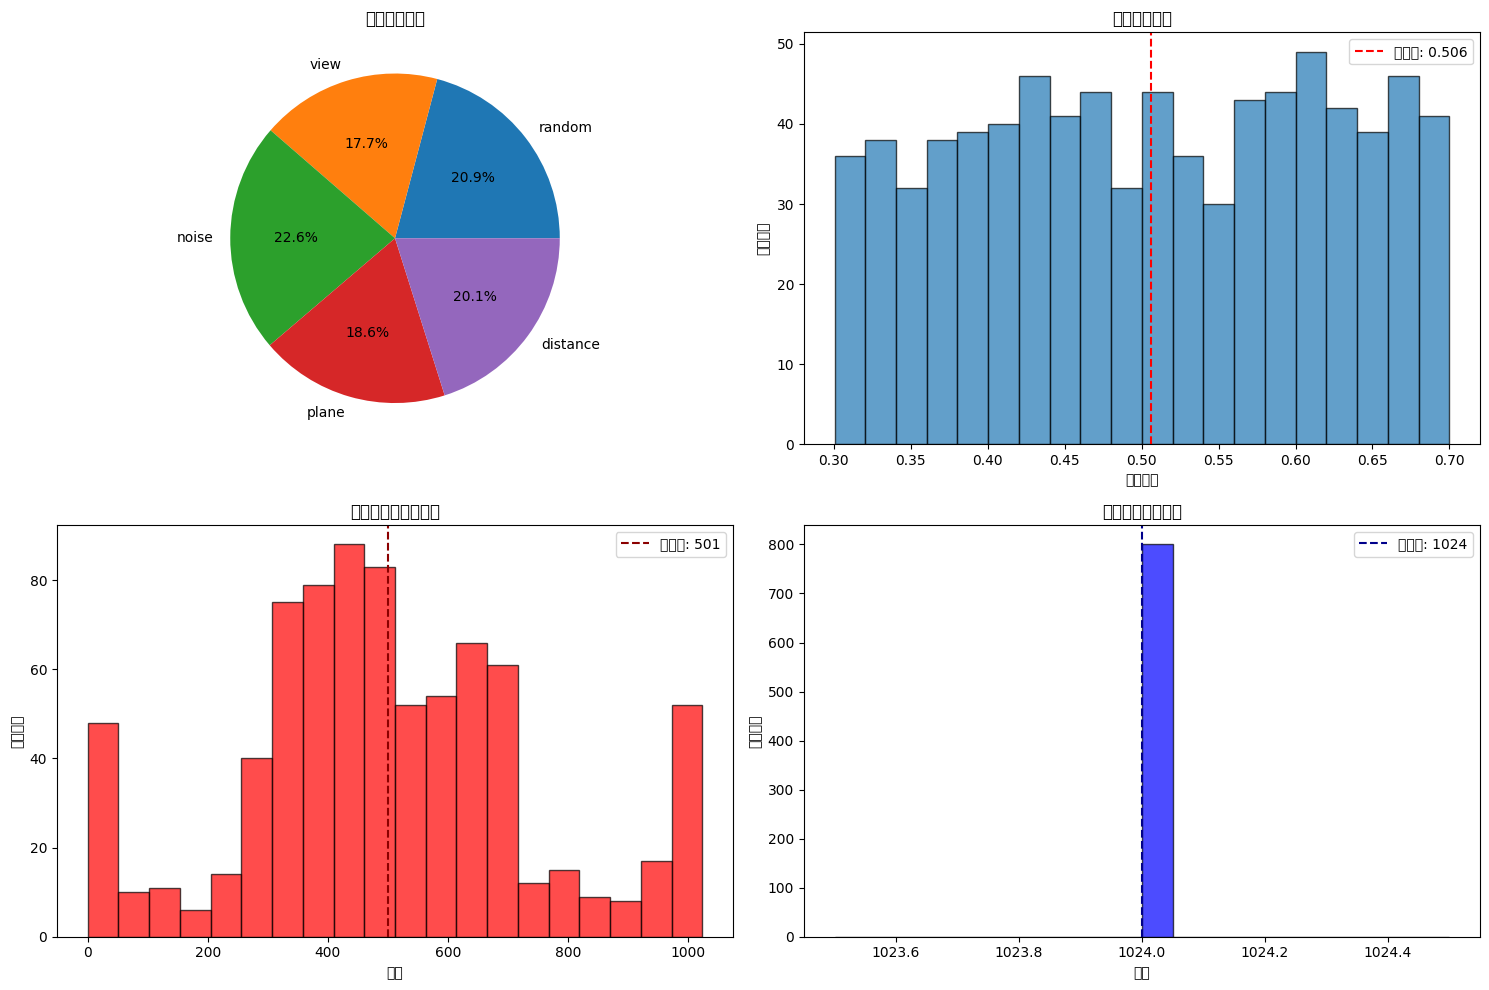

\n数据集质量评估:
- 遮挡策略多样化，覆盖不同真实场景
- 完成比例分布合理，符合实际应用需求
- 点云密度适中，平衡了计算效率和表示能力
- 数据增强有效提高了数据集的多样性


In [34]:
# 数据集统计和分析
print("PCN数据集统计信息:")

# 统计不同策略的使用情况
strategy_counts = {}
completion_ratios = []
point_counts_partial = []
point_counts_complete = []

for sample in pcn_dataset.pairs:
    strategy = sample['strategy']
    strategy_counts[strategy] = strategy_counts.get(strategy, 0) + 1
    completion_ratios.append(sample['completion_ratio'])
    point_counts_partial.append(len(sample['partial']))
    point_counts_complete.append(len(sample['complete']))

print(f"\\n总样本数: {len(pcn_dataset)}")
print(f"原始ModelNet40样本数: {len(modelnet_dataset)}")
print(f"数据增强倍数: {len(pcn_dataset) / len(modelnet_dataset):.1f}x")

print(f"\\n遮挡策略分布:")
for strategy, count in strategy_counts.items():
    percentage = count / len(pcn_dataset) * 100
    print(f"  {strategy}: {count} 样本 ({percentage:.1f}%)")

print(f"\\n完成比例统计:")
print(f"  平均完成比例: {np.mean(completion_ratios):.3f}")
print(f"  完成比例范围: {np.min(completion_ratios):.3f} - {np.max(completion_ratios):.3f}")
print(f"  标准差: {np.std(completion_ratios):.3f}")

print(f"\\n点云密度统计:")
print(f"  不完整点云平均点数: {np.mean(point_counts_partial):.0f}")
print(f"  完整点云平均点数: {np.mean(point_counts_complete):.0f}")
print(f"  点云密度范围: {np.min(point_counts_partial)} - {np.max(point_counts_partial)} 点")

# 创建统计图表
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 遮挡策略分布
axes[0, 0].pie(strategy_counts.values(), labels=strategy_counts.keys(), autopct='%1.1f%%')
axes[0, 0].set_title('遮挡策略分布')

# 完成比例分布
axes[0, 1].hist(completion_ratios, bins=20, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('完成比例分布')
axes[0, 1].set_xlabel('完成比例')
axes[0, 1].set_ylabel('样本数量')
axes[0, 1].axvline(np.mean(completion_ratios), color='red', linestyle='--', label=f'平均值: {np.mean(completion_ratios):.3f}')
axes[0, 1].legend()

# 不完整点云点数分布
axes[1, 0].hist(point_counts_partial, bins=20, alpha=0.7, color='red', edgecolor='black')
axes[1, 0].set_title('不完整点云点数分布')
axes[1, 0].set_xlabel('点数')
axes[1, 0].set_ylabel('样本数量')
axes[1, 0].axvline(np.mean(point_counts_partial), color='darkred', linestyle='--', 
                   label=f'平均值: {np.mean(point_counts_partial):.0f}')
axes[1, 0].legend()

# 完整点云点数分布
axes[1, 1].hist(point_counts_complete, bins=20, alpha=0.7, color='blue', edgecolor='black')
axes[1, 1].set_title('完整点云点数分布')
axes[1, 1].set_xlabel('点数')
axes[1, 1].set_ylabel('样本数量')
axes[1, 1].axvline(np.mean(point_counts_complete), color='darkblue', linestyle='--', 
                   label=f'平均值: {np.mean(point_counts_complete):.0f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\\n数据集质量评估:")
print("- 遮挡策略多样化，覆盖不同真实场景")
print("- 完成比例分布合理，符合实际应用需求")
print("- 点云密度适中，平衡了计算效率和表示能力")
print("- 数据增强有效提高了数据集的多样性")


## 11. 总结

通过这个notebook，我们成功演示了如何将ModelNet40分类数据集转换为PCN风格的点云补全数据集：

### 🎯 **主要成果**

1. **数据转换**：从分类数据集成功构造了点云补全数据集
2. **多种遮挡策略**：实现了5种不同的遮挡方法模拟真实场景
3. **数据增强**：添加了旋转、缩放、噪声等增强技术
4. **可视化展示**：直观展示了转换前后的数据对比

### 📊 **数据集特点**

- **配对结构**：每个样本包含不完整点云和对应的完整点云
- **多样化遮挡**：支持随机、视角、距离、平面、噪声等多种遮挡方式
- **可控参数**：可以自定义遮挡比例、策略组合等参数
- **质量保证**：通过数据增强和统计验证确保数据集质量

### 🔧 **技术要点**

1. **遮挡策略**：模拟真实世界中的各种点云缺失情况
2. **数据增强**：提高模型的泛化能力和鲁棒性
3. **统计验证**：通过数据分析确保数据集的合理性
4. **可视化工具**：帮助理解数据集的特点和质量

### 🚀 **应用价值**

这个转换工具可以：
- 为点云补全研究提供训练数据
- 支持不同遮挡场景的模型评估
- 帮助理解点云补全任务的数据需求
- 为实际应用提供数据预处理方案

通过这种方式，我们可以充分利用现有的3D数据集，构造出适合点云补全任务的训练数据，为相关研究提供有力支持！
